# Basic models

Let's try to compile basic model, try to visualize the model structure, generate some data, do basic training, try accessing layers' weights, save and load models and weights, try predicting values (perform inference).

If you  are using Tensorflow 2.x, then the model creation with Keras start by importing the necessary libraries. If you have a version with nVidia GPU support, then you can set environment variable to execute model on CPU or GPU:

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # '-1' is CPU, '0' - 1st GPU, '1' - 2nd GPU...

In [2]:
import tensorflow.keras as keras #we will be using keras module only

## Defining model

We need to define our model by giving input shape, layers and output.

Lets make the first model with just a single input, use 2 neurons dense layer with ReLU activation, then dense layer with 1 neuron and Sigmoid activation:

In [3]:
def define_small_model():
    # input will be a single floating point number
    model_input = keras.layers.Input(shape=(1,), dtype="float32", name="input")
    
    # first layer will be made of 2 neurons
    x = keras.layers.Dense(2, name="dense_layer_1")(model_input)
    
    # let's use ReLU activation after dense layer
    x = keras.activations.relu(x)
    
    # layer made of 1 neuron
    x = keras.layers.Dense(1, name="dense_layer_2")(x)
    
    # this time we use Sigmoid activation
    model_output = keras.activations.sigmoid(x)
    
    # now model inputs and outputs should be provided in a lists
    model = keras.Model(inputs=[model_input], outputs=[model_output])
    
    return model

## Model visualization

By calling the function we can get our model:

In [4]:
our_small_model = define_small_model()

Lets do some visualizations to see if the model is of the right structure and shape.
Basic check is by calling model summary:

In [5]:
our_small_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
dense_layer_1 (Dense)        (None, 2)                 4         
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 2)]               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 1)                 3         
_________________________________________________________________
tf_op_layer_Sigmoid (TensorF [(None, 1)]               0         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


By checking **Param #** column we can see how many parameters (usually weights) each layer has.

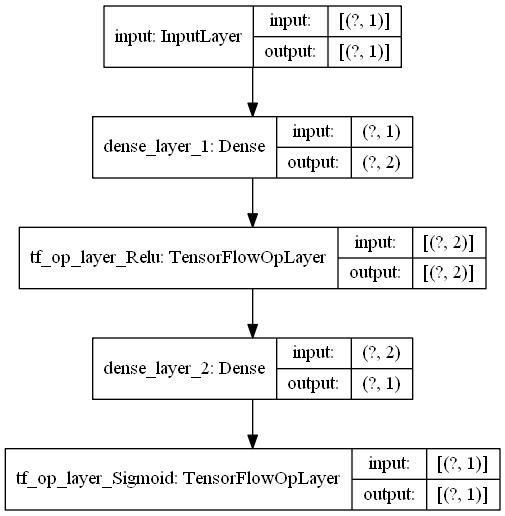

In [10]:
keras.utils.plot_model(our_small_model, to_file="our_small_model.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

Question mark points to batch size, as in all modern frameworks data is usually supplied in batches. Even a single sample is supplied as a batch of size 1. So a single number will be supplied as a matrix of size (1, 1).

Lets try another tiny model:

In [11]:
def define_tiny_model():
    # single input will be two floating point numbers supplied at the same time (vector of two number)
    model_input = keras.layers.Input(shape=(2,), dtype="float32", name="input")
    
    # single layer with 3 neurons and ReLU activation
    # activation could be defined as separate layer or as part of the current layer (if supported)
    model_output = keras.layers.Dense(3, use_bias=True, activation="relu", name="dense_1")(model_input)
    
    # now model inputs and outputs should be provided in a lists
    model = keras.Model(inputs=[model_input], outputs=[model_output])
    
    return model

In [12]:
our_tiny_model = define_tiny_model()

In [13]:
our_tiny_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


We have got total 9 trainable parameters. This is because we have a Dense layer (fully connected) with 3 neurons and input which is made of 2 numbers. So we have 2 x 3 = 6 weights and also we need to add biases (for every neuron in dense layer), 2 x 3 + 3 = 9 parameters.

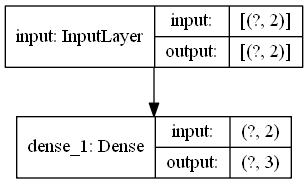

In [14]:
keras.utils.plot_model(our_tiny_model, to_file="our_tiny_model.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

## Model training

To train a model, we need input and output data. So lets import libraries to work with matrices and plotting tools.

In [15]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Our problem will be a $f(x) = sin(x)$ function defined in a range [-10;10].

In [16]:
input_data = np.linspace(-10, 10, num=1000)
#input_data = np.linspace(-1000, 1000, num=100000)
output_data = np.sin(input_data)

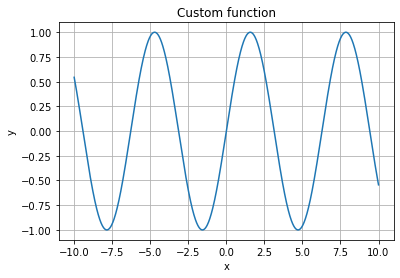

In [17]:
plt.figure()
plt.grid()
plt.title("Custom function")
plt.xlabel("x")
plt.ylabel("y")
#plt.plot(input_data[0:100], output_data[0:100]);
plt.plot(input_data, output_data);

Our problem is a regression as we are trying to predict a quantity.

We will define some experimental model with 5 layers, 1 input and 1 output. Take a note, that there is no activation function (linear activation) in the last layer as predicted quantity could be positive and negative.

In [18]:
def experimental_model():
    # single input will be two floating point numbers supplied at the same time (vector of two number)
    model_input = keras.layers.Input(shape=(1,), dtype="float32", name="input")
    
    # activation could be defined as separate layer or as part of the current layer (if supported)
    x = keras.layers.Dense(40, use_bias=True, activation="relu", name="dense_1")(model_input)
    x = keras.layers.Dense(30, use_bias=True, activation="relu", name="dense_2")(x)
    x = keras.layers.Dense(20, use_bias=True, activation="relu", name="dense_3")(x)
    x = keras.layers.Dense(10, use_bias=True, activation="relu", name="dense_4")(x)
    # we can use loops to add more layers
    #for i in range(5, 10):
    #    x = keras.layers.Dense(10, use_bias=True, activation="relu", name="dense_"+str(i))(x)
        
    model_output = keras.layers.Dense(1, use_bias=True, name="dense_output")(x)
    # now model inputs and outputs should be provided in a lists
    model = keras.Model(inputs=[model_input], outputs=[model_output])
    
    return model

After model is compiled its graph is static and it is ready to be trained. To compile model we need to define optimization algorithm (the one which will adjust weights of the model) [https://keras.io/api/optimizers/](https://keras.io/api/optimizers/), loss function [https://keras.io/api/losses/](https://keras.io/api/losses/) aka objective function (one which tell optimizer how to calculate error, and optimizer will try to minimize that error) and metrics (error(s) for visualization purposes) [https://keras.io/api/metrics/](https://keras.io/api/metrics/).

For optimizer it is recommended to start with **ADAM** (stochastic gradient descent with Adaptive Momentum) [https://keras.io/api/optimizers/adam/](https://keras.io/api/optimizers/adam/), then try **SGD** (Scaled Gradient Descent) [https://keras.io/api/optimizers/sgd/](https://keras.io/api/optimizers/sgd/) if **ADAM** is not working. Another good one to try is **RMSprop** [https://keras.io/api/optimizers/rmsprop/](https://keras.io/api/optimizers/rmsprop/).

During training [https://keras.io/api/models/model_training_apis/#fit-method](https://keras.io/api/models/model_training_apis/#fit-method) it is necessary to check if model is not overfitting the data. So we divide the data into train set and validation set by setting ```validation_split``` parameter, to determine percentage of data used for validation.

It is recommended to shuffle the data prior splitting into train and validation.

In [19]:
def shuffled_copies(a, b): #both arrays should have the same length
    p = np.random.permutation(len(a)) #get shuffled indexes
    return a[p], b[p]

shuffled_input_data, shuffled_output_data = shuffled_copies(input_data, output_data)

Let's create our model and visualize its structure:

In [20]:
model = experimental_model()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_output (Dense)         (None, 1)                 11        
Total params: 2,151
Trainable params: 2,151
Non-trainable params: 0
_________________________________________________________

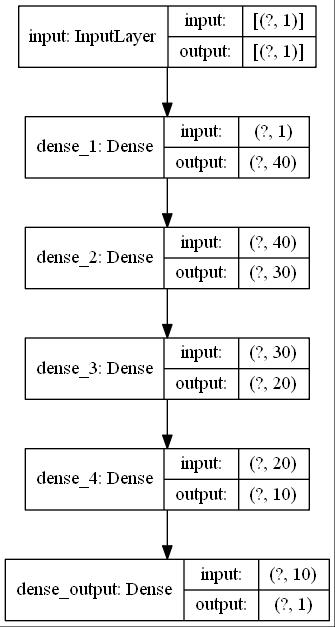

In [22]:
model.summary()
keras.utils.plot_model(model, to_file="experimental_model.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

Now we can define optimizer, loss function, metric, batch size, number of epochs, compile model (create static graph) and train it.

In [ ]:
opt = keras.optimizers.Adam()
#opt = keras.optimizers.RMSprop()
loss = keras.losses.MeanSquaredError()
metric_mae = keras.metrics.MeanAbsoluteError()

model.compile(optimizer=opt,
              loss=loss,
              metrics=[metric_mae],
              run_eagerly=False,)

In [30]:
batch_size = 2
epochs = 150
#epochs = 5

#model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.fit(shuffled_input_data,
          shuffled_output_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1);

Train on 900 samples, validate on 100 samples
Epoch 1/150
900/900 [==============================] - 1s 664us/sample - loss: 0.0152 - mean_absolute_error: 0.0724 - val_loss: 9.8627e-04 - val_mean_absolute_error: 0.0219
Epoch 2/150
900/900 [==============================] - 0s 357us/sample - loss: 0.0077 - mean_absolute_error: 0.0527 - val_loss: 0.0031 - val_mean_absolute_error: 0.0442
Epoch 3/150
900/900 [==============================] - 0s 356us/sample - loss: 0.0167 - mean_absolute_error: 0.0790 - val_loss: 0.0051 - val_mean_absolute_error: 0.0497
Epoch 4/150
900/900 [==============================] - 0s 352us/sample - loss: 0.0134 - mean_absolute_error: 0.0606 - val_loss: 0.1407 - val_mean_absolute_error: 0.2742
Epoch 5/150
900/900 [==============================] - 0s 353us/sample - loss: 0.0673 - mean_absolute_error: 0.1612 - val_loss: 0.1083 - val_mean_absolute_error: 0.1762
Epoch 6/150
900/900 [==============================] - 0s 358us/sample - loss: 0.0501 - mean_absolute_err

Epoch 49/150
900/900 [==============================] - 0s 370us/sample - loss: 0.0128 - mean_absolute_error: 0.0642 - val_loss: 0.0111 - val_mean_absolute_error: 0.0665
Epoch 50/150
900/900 [==============================] - 0s 356us/sample - loss: 0.0052 - mean_absolute_error: 0.0461 - val_loss: 0.0025 - val_mean_absolute_error: 0.0355
Epoch 51/150
900/900 [==============================] - 0s 351us/sample - loss: 0.0076 - mean_absolute_error: 0.0532 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411
Epoch 52/150
900/900 [==============================] - 0s 362us/sample - loss: 0.0267 - mean_absolute_error: 0.0929 - val_loss: 0.0193 - val_mean_absolute_error: 0.0890
Epoch 53/150
900/900 [==============================] - 0s 367us/sample - loss: 0.0055 - mean_absolute_error: 0.0450 - val_loss: 0.0062 - val_mean_absolute_error: 0.0532
Epoch 54/150
900/900 [==============================] - 0s 372us/sample - loss: 0.0052 - mean_absolute_error: 0.0495 - val_loss: 0.0096 - val_mean_abs

900/900 [==============================] - 0s 357us/sample - loss: 0.0031 - mean_absolute_error: 0.0339 - val_loss: 0.0028 - val_mean_absolute_error: 0.0432
Epoch 98/150
900/900 [==============================] - 0s 361us/sample - loss: 0.0096 - mean_absolute_error: 0.0588 - val_loss: 0.0042 - val_mean_absolute_error: 0.0381
Epoch 99/150
900/900 [==============================] - 0s 359us/sample - loss: 0.0054 - mean_absolute_error: 0.0490 - val_loss: 0.0037 - val_mean_absolute_error: 0.0416
Epoch 100/150
900/900 [==============================] - 0s 358us/sample - loss: 0.0041 - mean_absolute_error: 0.0391 - val_loss: 0.0050 - val_mean_absolute_error: 0.0600
Epoch 101/150
900/900 [==============================] - 0s 353us/sample - loss: 0.0067 - mean_absolute_error: 0.0473 - val_loss: 0.0146 - val_mean_absolute_error: 0.0939
Epoch 102/150
900/900 [==============================] - 0s 356us/sample - loss: 0.0069 - mean_absolute_error: 0.0539 - val_loss: 0.0057 - val_mean_absolute_erro

Epoch 145/150
900/900 [==============================] - 0s 360us/sample - loss: 0.0031 - mean_absolute_error: 0.0387 - val_loss: 0.0017 - val_mean_absolute_error: 0.0332
Epoch 146/150
900/900 [==============================] - 0s 369us/sample - loss: 0.0018 - mean_absolute_error: 0.0273 - val_loss: 9.0436e-04 - val_mean_absolute_error: 0.0184
Epoch 147/150
900/900 [==============================] - 0s 370us/sample - loss: 0.0016 - mean_absolute_error: 0.0276 - val_loss: 0.0016 - val_mean_absolute_error: 0.0210
Epoch 148/150
900/900 [==============================] - 0s 358us/sample - loss: 0.0081 - mean_absolute_error: 0.0547 - val_loss: 0.0027 - val_mean_absolute_error: 0.0337
Epoch 149/150
900/900 [==============================] - 0s 359us/sample - loss: 0.0049 - mean_absolute_error: 0.0429 - val_loss: 0.0072 - val_mean_absolute_error: 0.0477
Epoch 150/150
900/900 [==============================] - 0s 351us/sample - loss: 0.0015 - mean_absolute_error: 0.0260 - val_loss: 0.0016 - va

In [31]:
predicted_data = model.predict(input_data)

(1000, 1)


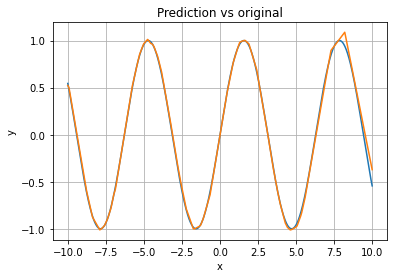

In [32]:
plt.figure()
plt.grid()
plt.title("Prediction vs original")
plt.xlabel("x")
plt.ylabel("y")
#plt.plot(input_data[0:1000], output_data[0:1000], input_data[0:1000], predicted_data[0:1000]);
plt.plot(input_data, output_data, input_data, predicted_data);
print(predicted_data.shape)

## Saving model and weights

It is recommended to save model and model weights every epoch, so later it is possible to look through models and get the most suitable one.

When saving model, model structure, weights and optimizer state are saved. When saving weights only, you don't have information on model structure or state of optimizer, so it is recommended to have model structure source file.

Model saving is done via `keras.models.save_model` function. If you don't know the function options, type function name with a question mark `keras.models.save_model?` and execute cell.

In [ ]:
keras.models.save_model?

In [35]:
model.save_weights?

In [36]:
# to get help use model.save?
#model.save("sine_function_model.h5") #old approach
keras.models.save_model(model, "sine_function_model.h5")
model.save_weights("sine_function_model_weights.h5")

Model could be deleted from memory and then loaded again easy:

In [37]:
del model #delete model
model = keras.models.load_model("sine_function_model.h5")

If we create custom layers or custom activations, then such saved model may not load as those custom modifications are not present in keras library. In such a case we need to recreate model structure from the function and then load weights.

In [38]:
del model #delete model
model = experimental_model()
model.load_weights("sine_function_model_weights.h5")

After loading we may again perform an inference by supplying `input_data` and noting the predictions.

In [39]:
predicted_data = model.predict(input_data)

(1000, 1)


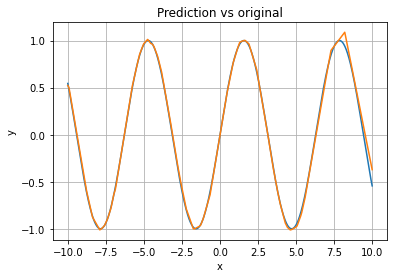

In [40]:
plt.figure()
plt.grid()
plt.title("Prediction vs original")
plt.xlabel("x")
plt.ylabel("y")
#plt.plot(input_data[0:100], output_data[0:100]);
#plt.plot(input_data, predicted_data);
plt.plot(input_data, output_data, input_data, predicted_data);
print(predicted_data.shape)

## Model testing

We can try to extend the range and check how well the model performs outside of the train range (how well model extrapolates)

In [41]:
input_data_long = np.linspace(-20, 20, num=1000)
output_data_long = np.sin(input_data_long)

In [42]:
predicted_data_long = model.predict(input_data_long)

(1000, 1)


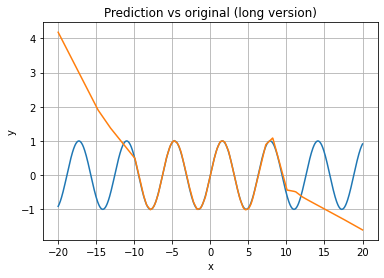

In [44]:
plt.figure()
plt.grid()
plt.title("Prediction vs original (long version)")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(input_data_long, output_data_long, input_data_long, predicted_data_long);
print(predicted_data_long.shape)

Outside of training data model behaves poorly. Because of these reasons:
* We are trying to model periodic function with non-periodic activations. For such task we need a lot of memory (wide feed forward model) to memorize all values from all usable range.
* Or we need a periodic activation function for our feed forward model (we will try that later).
* Or use model which can remember previous states (recurrent model based on LSTM or GRU).

## Manipulations with weights

Reading weights of trained model may help to understand why model is performing poorly. Also weights may be adjusted or transfered to other model.

When building model it is recommended to provide names to model layers, so later you can access layers by name instead of by index [https://keras.io/api/layers/base_layer/#get_weights-method](https://keras.io/api/layers/base_layer/#get_weights-method):

In [45]:
one_layer = model.get_layer(name="dense_1")
one_layer_weights = one_layer.get_weights()

In [46]:
print(one_layer_weights[0].shape)
print(one_layer_weights[1].shape)
print(one_layer_weights)

(1, 40)
(40,)
[array([[-5.18808328e-02,  2.34572068e-01,  4.90400754e-02,
        -1.81736927e-02, -1.72318354e-01, -5.84388115e-02,
        -2.85289343e-03, -9.62202344e-03, -4.85205576e-02,
         2.71751791e-01,  1.65882304e-01, -1.17067762e-01,
         2.67908365e-01, -4.72217835e-02, -1.49385288e-01,
        -7.63814747e-02,  7.45111778e-02, -2.67571032e-01,
        -2.55703688e-01,  8.01622955e-05, -2.42646853e-03,
        -1.58186793e-01, -7.68828765e-02,  1.99534614e-02,
        -7.20859915e-02, -2.71840598e-02, -3.31660296e-04,
        -1.90524235e-01, -9.73771885e-02, -1.07749894e-01,
         9.90960747e-04,  2.21855819e-01,  5.75437322e-02,
        -2.00918992e-03, -2.23802810e-04, -1.43751413e-01,
         3.07664450e-04,  1.51897475e-01, -1.67098492e-01,
         5.40039241e-02]], dtype=float32), array([-0.5923428 , -0.79058546, -0.53910637,  0.03124907, -0.8647948 ,
        0.7364563 ,  0.896859  ,  0.09585071, -0.5093827 , -0.65532035,
       -0.810591  ,  0.15225457

Same weights are available when accessing layer by index:

In [47]:
one_layer = model.get_layer(index=1)
one_layer_weights = one_layer.get_weights()

In [48]:
print(one_layer_weights[0].shape)
print(one_layer_weights[1].shape)
print(one_layer_weights)

(1, 40)
(40,)
[array([[-5.18808328e-02,  2.34572068e-01,  4.90400754e-02,
        -1.81736927e-02, -1.72318354e-01, -5.84388115e-02,
        -2.85289343e-03, -9.62202344e-03, -4.85205576e-02,
         2.71751791e-01,  1.65882304e-01, -1.17067762e-01,
         2.67908365e-01, -4.72217835e-02, -1.49385288e-01,
        -7.63814747e-02,  7.45111778e-02, -2.67571032e-01,
        -2.55703688e-01,  8.01622955e-05, -2.42646853e-03,
        -1.58186793e-01, -7.68828765e-02,  1.99534614e-02,
        -7.20859915e-02, -2.71840598e-02, -3.31660296e-04,
        -1.90524235e-01, -9.73771885e-02, -1.07749894e-01,
         9.90960747e-04,  2.21855819e-01,  5.75437322e-02,
        -2.00918992e-03, -2.23802810e-04, -1.43751413e-01,
         3.07664450e-04,  1.51897475e-01, -1.67098492e-01,
         5.40039241e-02]], dtype=float32), array([-0.5923428 , -0.79058546, -0.53910637,  0.03124907, -0.8647948 ,
        0.7364563 ,  0.896859  ,  0.09585071, -0.5093827 , -0.65532035,
       -0.810591  ,  0.15225457

It is possible to get all weights at once:

In [49]:
all_weights = model.get_weights()

In [50]:
print("total weights arrays available:", len(all_weights))
for i, weights in enumerate(all_weights):
    print(i, weights.shape)

total weights arrays available: 10
0 (1, 40)
1 (40,)
2 (40, 30)
3 (30,)
4 (30, 20)
5 (20,)
6 (20, 10)
7 (10,)
8 (10, 1)
9 (1,)


It is possible to manually modify weights and set them back into layer [https://keras.io/api/layers/base_layer/#set_weights-method](https://keras.io/api/layers/base_layer/#set_weights-method):

In [51]:
one_layer = model.get_layer(name="dense_1")
one_layer_weights = one_layer.get_weights()

Modify just one value

In [52]:
#the first layer "dense_1" weigths (weights have index 0, biases index 1) have shape (1, 40)
#we change second value at index 1
one_layer_weights[0][0][1] = -10 # [weights index][0 - as there just one input][1 - because we change second weight]
one_layer.set_weights(one_layer_weights)

and observe the result

In [53]:
predicted_data = model.predict(input_data)

(1000, 1)


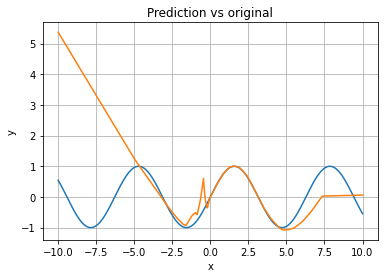

In [54]:
plt.figure()
plt.grid()
plt.title("Prediction vs original")
plt.xlabel("x")
plt.ylabel("y")
#plt.plot(input_data[0:100], output_data[0:100]);
#plt.plot(input_data, predicted_data);
plt.plot(input_data, output_data, input_data, predicted_data);
print(predicted_data.shape)

## Custom activation functions

We can try and make a model with a custom activation function.

In [55]:
# you can try this activation too
def sin_activation(x):
    return keras.backend.sin(x)

# we will use this periodic function
def cos_activation(x):
    return keras.backend.cos(x)

def experimental_model2():
    # single input will be two floating point numbers supplied at the same time (vector of two number)
    model_input = keras.layers.Input(shape=(1,), dtype="float32", name="input")

    # activation could be defined as separate layer or as part of the current layer (if supported)
    x = keras.layers.Dense(40, use_bias=True, activation=cos_activation, name="dense_1")(model_input)
    x = keras.layers.Dense(30, use_bias=True, activation=cos_activation, name="dense_2")(x)
    x = keras.layers.Dense(20, use_bias=True, activation=cos_activation, name="dense_3")(x)
    x = keras.layers.Dense(10, use_bias=True, activation=cos_activation, name="dense_4")(x)
    model_output = keras.layers.Dense(1, use_bias=True, name="dense_output")(x)
    # now model inputs and outputs should be provided in a lists
    model = keras.Model(inputs=[model_input], outputs=[model_output])
    
    return model

# you can try to experiment with smaller models and see if it is possible to get low loss on train and validation data
# try adding more layers and train again
def experimental_model3():
    # single input will be two floating point numbers supplied at the same time (vector of two number)
    model_input = keras.layers.Input(shape=(1,), dtype="float32", name="input")
    # activation could be defined as separate layer or as part of the current layer (if supported)
    model_output = keras.layers.Dense(1, use_bias=True, activation=cos_activation, name="dense_1")(model_input)
    # now model inputs and outputs should be provided in a lists
    model = keras.Model(inputs=[model_input], outputs=[model_output])
    
    return model

Lets build a model and train it

In [56]:
model2 = experimental_model2()

# uncomment this line if you wish to test experimental_model3()
#model2 = experimental_model3()

opt = keras.optimizers.Adam()
#opt = keras.optimizers.RMSprop()
loss = keras.losses.MeanSquaredError()
metric_mae = keras.metrics.MeanAbsoluteError()
model2.compile(optimizer=opt,
              loss=loss,
              metrics=[metric_mae],
              run_eagerly=False,)

batch_size = 16
epochs = 50

#model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model2.fit(shuffled_input_data,
           shuffled_output_data,
           batch_size=batch_size,
           epochs=epochs,
           validation_split=0.1);


Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 389us/sample - loss: 0.5992 - mean_absolute_error: 0.6590 - val_loss: 0.4815 - val_mean_absolute_error: 0.6107
Epoch 2/50
900/900 [==============================] - 0s 56us/sample - loss: 0.4678 - mean_absolute_error: 0.6107 - val_loss: 0.4492 - val_mean_absolute_error: 0.5903
Epoch 3/50
900/900 [==============================] - 0s 54us/sample - loss: 0.4083 - mean_absolute_error: 0.5661 - val_loss: 0.3004 - val_mean_absolute_error: 0.4807
Epoch 4/50
900/900 [==============================] - 0s 54us/sample - loss: 0.1857 - mean_absolute_error: 0.3583 - val_loss: 0.0503 - val_mean_absolute_error: 0.1798
Epoch 5/50
900/900 [==============================] - 0s 54us/sample - loss: 0.0373 - mean_absolute_error: 0.1514 - val_loss: 0.0213 - val_mean_absolute_error: 0.1254
Epoch 6/50
900/900 [==============================] - 0s 54us/sample - loss: 0.0194 - mean_absolute_error: 0.1097 - va

900/900 [==============================] - 0s 53us/sample - loss: 2.5180e-04 - mean_absolute_error: 0.0119 - val_loss: 2.3501e-04 - val_mean_absolute_error: 0.0122
Epoch 49/50
900/900 [==============================] - 0s 53us/sample - loss: 5.2397e-04 - mean_absolute_error: 0.0157 - val_loss: 1.7231e-04 - val_mean_absolute_error: 0.0097
Epoch 50/50
900/900 [==============================] - 0s 56us/sample - loss: 2.5201e-04 - mean_absolute_error: 0.0108 - val_loss: 1.4343e-04 - val_mean_absolute_error: 0.0095


In [57]:
predicted_data = model2.predict(input_data)

(1000, 1)


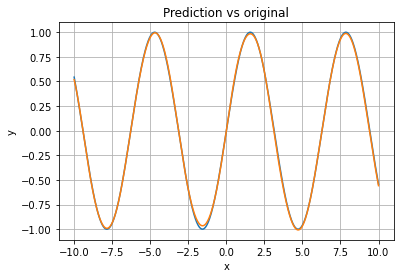

In [58]:
plt.figure()
plt.grid()
plt.title("Prediction vs original")
plt.xlabel("x")
plt.ylabel("y")
#plt.plot(input_data[0:100], output_data[0:100]);
#plt.plot(input_data, predicted_data);
plt.plot(input_data, output_data, input_data, predicted_data);
print(predicted_data.shape)

Looks good on a limited set of data. But how will it behave if we extend the range of input values?

In [59]:
input_data_long = np.linspace(-20, 20, num=1000)
output_data_long = np.sin(input_data_long)

In [60]:
predicted_data_long = model2.predict(input_data_long)

(1000, 1)


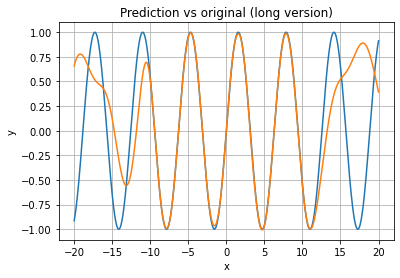

In [61]:
plt.figure()
plt.grid()
plt.title("Prediction vs original (long version)")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(input_data_long, output_data_long, input_data_long, predicted_data_long);
print(predicted_data_long.shape)

We saw the results, model overfits: result is good on limited range of train data (low bias) and bad on a wider set of test data (high variance). Here one problem is that test data is from a different range. Solution could be to provide more data or simplify the model. Because even with periodic activation functions we couldn't get model to perform well, the problem may be that our train data was not representing periodicy well. So now we make a big dataset with a wider range of values to better represent the periodicy of the data.

In [62]:
input_data_big = np.linspace(-1000, 1000, num=100000)
output_data_big = np.sin(input_data_big)

In [63]:
shuffled_input_data_big, shuffled_output_data_big = shuffled_copies(input_data_big, output_data_big)

In [ ]:
# if you comment line below, you will use previous model pre-trained on small set
# that could help if current model is not training on a large set
#model2 = experimental_model2() 

opt = keras.optimizers.Adam()
#opt = keras.optimizers.RMSprop()
loss = keras.losses.MeanSquaredError()
metric_mae = keras.metrics.MeanAbsoluteError()
model2.compile(optimizer=opt,
              loss=loss,
              metrics=[metric_mae],
              run_eagerly=False,)

In [91]:
os.makedirs("weights", exist_ok=True) #make folder for storing model weights

#let's save promising models during training
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                                                            save_weights_only=True, #saving weights, as we have custom activation
                                                            monitor='val_loss', #we will watch validation loss
                                                            mode='min', #we want to save minimum validation loss only
                                                            save_best_only=True)


batch_size = 16
epochs = 50

#we will store training history in train_history
train_history = model2.fit(shuffled_input_data_big,
                           shuffled_output_data_big,
                           batch_size=batch_size,
                           epochs=epochs,
                           callbacks=[model_checkpoint_callback],
                           validation_split=0.1);

Train on 90000 samples, validate on 10000 samples
Epoch 1/50
90000/90000 [==============================] - 1s 15us/sample - loss: 8.8738e-05 - mean_absolute_error: 0.0072 - val_loss: 2.7414e-04 - val_mean_absolute_error: 0.0129
Epoch 2/50
90000/90000 [==============================] - 1s 13us/sample - loss: 3.2942e-04 - mean_absolute_error: 0.0111 - val_loss: 1.0328e-04 - val_mean_absolute_error: 0.0079
Epoch 3/50
90000/90000 [==============================] - 1s 13us/sample - loss: 3.9274e-04 - mean_absolute_error: 0.0124 - val_loss: 2.7030e-04 - val_mean_absolute_error: 0.0128
Epoch 4/50
90000/90000 [==============================] - 1s 13us/sample - loss: 6.3428e-04 - mean_absolute_error: 0.0138 - val_loss: 7.6619e-05 - val_mean_absolute_error: 0.0069
Epoch 5/50
90000/90000 [==============================] - 1s 13us/sample - loss: 5.0852e-04 - mean_absolute_error: 0.0117 - val_loss: 9.3405e-04 - val_mean_absolute_error: 0.0241
Epoch 6/50
90000/90000 [==============================]

90000/90000 [==============================] - 1s 13us/sample - loss: 3.0203e-04 - mean_absolute_error: 0.0087 - val_loss: 2.8704e-04 - val_mean_absolute_error: 0.0136
Epoch 47/50
90000/90000 [==============================] - 1s 13us/sample - loss: 2.8554e-04 - mean_absolute_error: 0.0087 - val_loss: 2.5191e-05 - val_mean_absolute_error: 0.0041
Epoch 48/50
90000/90000 [==============================] - 1s 13us/sample - loss: 2.6054e-04 - mean_absolute_error: 0.0076 - val_loss: 3.2460e-04 - val_mean_absolute_error: 0.0141
Epoch 49/50
90000/90000 [==============================] - 1s 13us/sample - loss: 3.6627e-04 - mean_absolute_error: 0.0082 - val_loss: 8.8163e-06 - val_mean_absolute_error: 0.0024
Epoch 50/50
90000/90000 [==============================] - 1s 13us/sample - loss: 2.4719e-04 - mean_absolute_error: 0.0080 - val_loss: 3.5740e-05 - val_mean_absolute_error: 0.0049


`fit` method returns train history dictionary, which could be used to check model performance during training. Let's see what keys are available:

In [92]:
print(train_history.history.keys())
print("Items in 'loss' key:", len(train_history.history['loss']))

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])
Items in 'loss' key: 50


We would like to compare `loss` (on train set) and `val_loss` (validation loss on dev set).

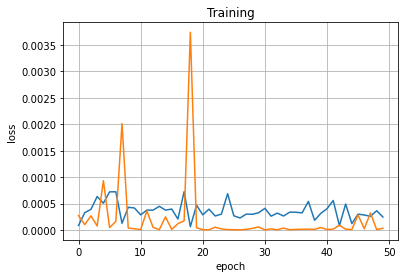

In [93]:
epochs = list(range(len(train_history.history['loss'])))

plt.figure()
plt.grid()
plt.title("Training")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.plot(input_data[0:100], output_data[0:100]);
#plt.plot(input_data, predicted_data);
plt.plot(epochs, train_history.history['loss'], epochs, train_history.history['val_loss']);

TODO: Add loading best model and testing it.

In [94]:
input_data_long = np.linspace(-5000, -4990, num=1000)
output_data_long = np.sin(input_data_long)

In [95]:
predicted_data_long = model2.predict(input_data_long)

(1000, 1)


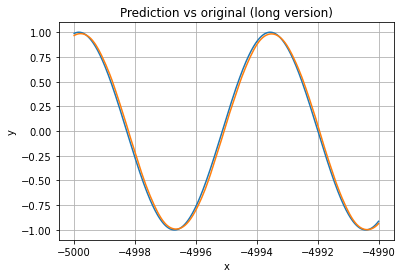

In [96]:
plt.figure()
plt.grid()
plt.title("Prediction vs original (long version)")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(input_data_long, output_data_long, input_data_long, predicted_data_long);
print(predicted_data_long.shape)

As we can see our test data is way outside of the train range and model is still behaving well. So conclusion could be that model learned periodicy of data well.